In [257]:
import redis
import json
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
import contractions
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance

redis connection

In [336]:
r = redis.Redis(host='redis-12442.c90.us-east-1-3.ec2.cloud.redislabs.com',port=12442,password='RHFgwK2pQ2ibFUqw8zrQBHRzK29lQtDw')
keys=r.keys('*') #getting the keys of each convesation
print(len(keys))

90


grouping all intents together as a dictionary

In [337]:
trackerdata=[]
for i in keys: 
    temp=r[i]
    temp = temp.decode("utf-8")
    trackerdata.append(json.loads(temp)) #each conversation is saved with its events as a list and trackername
conversations=[]
for i in trackerdata:
    conversations.append(i["events"]) #extracting only the events list of each conversation
intents=set()
intentdictnew=dict()
for conv in conversations:
    for i in conv:# extracting the intents from the conversations
        if i['event']=="user":
            if i['parse_data']['intent']['name'] not in intents:
                intents.add(i['parse_data']['intent']['name'])
                intentdictnew[i['parse_data']['intent']['name']]={i["text"]}
            else:
                intentdictnew[i['parse_data']['intent']['name']].add(i["text"])
for k,v in intentdictnew.items():
    print(k,":",v)



price_details : {'price detaisl', 'i want the item details', '/price_details', 'price details', 'price detaosl'}
get_item_prices : {'/get_item_prices', 'item ifno'}
get_specific_price : {'/get_specific_price', 'cost of particular item', 'particular item particular location'}
item_details : {'100185305', 'loc is 246001', '105', '607', '100035001', 'the number is 100150000', '1000350001', '10035001', 'what is 454 calendar?', 'it is 607', 'what is 4-5-4 calender?', '100140001', '100140000', '246001', 'what is 454 calender in retail?', '100150000', 'give adhipursh review'}
location_details : {'location 607', 'location 246001', 'location 105', 'loc is 607', 'price details for location 607', 'loc 607'}
hello : {'/hello'}
continue_info : {'yes', 'RMS'}
get_item_all_locs : {'cost of all items in particular location', '/get_item_all_locs', 'UPC in RMS'}
deny : {'no', 'vendor', 'what is vendor', 'i want the trichy weather', '/stop'}
greet : {'hey', 'how is the weather in trichy', 'sup', 'adipuru

DESCRIPTIVE ANALYSIS OF UNRECOGNISED USER INPUTS

In [326]:
newinputs=intentdictnew["nlu_fallback"] | intentdictnew["others"]
print(newinputs)

{'/action_get_item_prices', 'prime minister of india', 'what is the weather in chennai', 'hows the weather like in chennai', 'president of india', 'list IT companies in chennai', 'what is python', 'list IT companies chennai', 'cheif minister of tamilnadu', 'what is the weather like', '607', 'what is replenishment ?', 'hwta is UPC', 'what is RMS', 'upc oracle', 'what is the weather condition in trichy', 'list states in tamilnadu', 'who is the cheoif minister of tamilnadu', 'UPC in retail', 'how is the climate', 'what is climatic change', 'what is the weather in madurai', 'how is the weather like', 'rasa', 'loc is 607', 'what is Stock Ledger in retail domain', '/others', 'i want the iem details', '100035001', 'how is the climate like', 'what is the climate', 'what is the weather in trichy', 'prime minister of tamilnadu', 'what is UPC', 'UPC', 'who is vendor', 'what is the wetaher like', 'what is the weather', 'who is the cheif minister of tamilnadu', 'what is RASA', '100150000', 'list st

PREPROCESSING THE DATA

In [327]:
#removing button inputs
newinputs2=set()
for i in newinputs:
    if i[0]!='/':
        newinputs2.add(i.lower())
newinputs2=list(newinputs2)
print(newinputs2)

['prime minister of india', 'what is upc', 'what is the weather in chennai', 'list it companies chennai', 'hows the weather like in chennai', 'president of india', 'what is python', 'cheif minister of tamilnadu', 'what is the weather like', '607', 'list it companies in chennai', 'what is replenishment ?', 'upc oracle', 'upc', 'what is the weather condition in trichy', 'list states in tamilnadu', 'who is the cheoif minister of tamilnadu', 'how is the climate', 'upc in retail', 'what is climatic change', 'what is the weather in madurai', 'how is the weather like', 'what is stock ledger in retail domain', 'rasa', 'loc is 607', 'what is rasa', 'i want the iem details', '100035001', 'how is the climate like', 'what is rms', 'what is the climate', 'what is the weather in trichy', 'prime minister of tamilnadu', 'what is the weather', 'who is vendor', 'what is the wetaher like', 'who is the cheif minister of tamilnadu', '100150000', 'list states in india', 'hwta is upc']


In [262]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [264]:
def cleaning_contractions(text):
    text=text.split()
    corrected=[]
    for word in text:
        corrected.append(contractions.fix(word))
    return " ".join(corrected)

In [265]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    return re.sub(re.compile("["+punctuations_list+"‼️’]")," ",text)

In [267]:
#nltk.download('stopwords')
stop_words = stopwords.words('english')
def cleaning_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [268]:
def correct_word_spelling(sentence):
    words=sentence.split()
    words2=[]
    for word in words:
        word = Word(word)
        words2.append(word.correct())
    return(" ".join(words2))

In [328]:
#performing all data cleaning operations

cleanedinputs=[]# stores the cleaned data
wordmap=dict()
for i in newinputs2:
    temp=cleaning_numbers(i)
    temp=cleaning_contractions(temp)
    #temp=correct_word_spelling(temp)
    temp=cleaning_punctuations(temp)
    temp=cleaning_stopwords(temp)
    if temp!="":
        cleanedinputs.append(temp)
        keys=set(wordmap.keys())
        for j in temp.split():
            if j not in keys:
                wordmap[j]=[i]
            else:
                wordmap[j].append(i) #mapping the maps to their sentences


wordmap: a dictionary that maps the word to a set of the sentences it is present in

In [329]:
for k,v in wordmap.items():
    print(k,":",v)

prime : ['prime minister of india', 'prime minister of tamilnadu']
minister : ['prime minister of india', 'cheif minister of tamilnadu', 'who is the cheoif minister of tamilnadu', 'prime minister of tamilnadu', 'who is the cheif minister of tamilnadu']
india : ['prime minister of india', 'president of india', 'list states in india']
upc : ['what is upc', 'upc oracle', 'upc', 'upc in retail', 'hwta is upc']
weather : ['what is the weather in chennai', 'hows the weather like in chennai', 'what is the weather like', 'what is the weather condition in trichy', 'what is the weather in madurai', 'how is the weather like', 'what is the weather in trichy', 'what is the weather']
chennai : ['what is the weather in chennai', 'list it companies chennai', 'hows the weather like in chennai', 'list it companies in chennai']
list : ['list it companies chennai', 'list it companies in chennai', 'list states in tamilnadu', 'list states in india']
companies : ['list it companies chennai', 'list it compani

wordcount: mapping words to their count 

In [339]:
words=[]
for i in cleanedinputs:
    words.extend(i.split())
#print(words)
wordcount=Counter(words) #counting occurance of each word using counter class
print(wordcount)
#for k,v in wordcount.items():
#    print (k,":",v)

Counter({'weather': 8, 'minister': 5, 'upc': 5, 'like': 5, 'tamilnadu': 5, 'chennai': 4, 'list': 4, 'india': 3, 'climate': 3, 'prime': 2, 'companies': 2, 'cheif': 2, 'trichy': 2, 'states': 2, 'retail': 2, 'rasa': 2, 'president': 1, 'python': 1, 'replenishment': 1, 'oracle': 1, 'condition': 1, 'cheoif': 1, 'climatic': 1, 'change': 1, 'madurai': 1, 'stock': 1, 'ledger': 1, 'domain': 1, 'loc': 1, 'want': 1, 'iem': 1, 'details': 1, 'rms': 1, 'vendor': 1, 'wetaher': 1, 'hwta': 1})


wordcloud visualisation

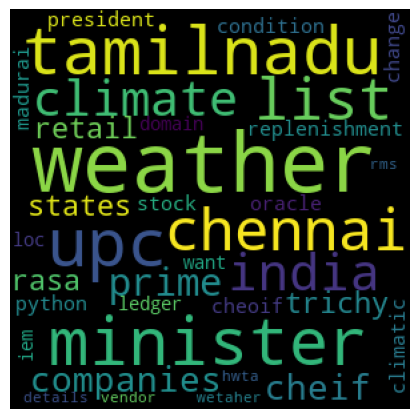

In [340]:
comment_words = " ".join(words)+ " "
#print(comment_words)
wordcloud = WordCloud(width = 300, height = 300,background_color ='black',min_font_size = 10).generate(comment_words)
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


AFFINITY PROPOGATION CLUSTERING using levenshtein distance metric

In [341]:
words = np.asarray(words) #So that indexing with a list will work
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

affprop = AffinityPropagation(affinity="precomputed")
affprop.fit(lev_similarity)

clusters=dict()#stores the cluster label and the values

for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]] #the clusterlabel
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)]).tolist() #cluster values
    count=[wordcount[i] for i in cluster]
    totalcount=sum(count)
    d=dict() # creating a dictionary with key as clusterlabel, values as the totalcount,the cluster words and their indivial count
    d['total_count']=totalcount
    d['words']=cluster
    d['word count']=count
    clusters[exemplar]=d

for k,v in clusters.items():
    print(k,":")
    for k1,v1 in v.items():
        print("\t",k1,":",v1)

# you can access the sentence the words are present in using wordmap 
#eg.  wordmap[clusters["companies"]["words"][0]]  will give all sentences in which the word companies is present

prime :
	 total_count : 3
	 words : ['president', 'prime']
	 word count : [1, 2]
india :
	 total_count : 5
	 words : ['india', 'madurai', 'vendor']
	 word count : [3, 1, 1]
weather :
	 total_count : 10
	 words : ['python', 'weather', 'wetaher']
	 word count : [1, 8, 1]
list :
	 total_count : 5
	 words : ['iem', 'list']
	 word count : [1, 4]
chennai :
	 total_count : 4
	 words : ['chennai']
	 word count : [4]
cheif :
	 total_count : 4
	 words : ['change', 'cheif', 'cheoif']
	 word count : [1, 2, 1]
minister :
	 total_count : 5
	 words : ['minister']
	 word count : [5]
like :
	 total_count : 6
	 words : ['ledger', 'like']
	 word count : [1, 5]
companies :
	 total_count : 2
	 words : ['companies']
	 word count : [2]
replenishment :
	 total_count : 1
	 words : ['replenishment']
	 word count : [1]
upc :
	 total_count : 6
	 words : ['loc', 'upc']
	 word count : [1, 5]
condition :
	 total_count : 1
	 words : ['condition']
	 word count : [1]
trichy :
	 total_count : 2
	 words : ['trichy']
	 wo

sorting the clusters in descending

In [345]:
clusters = sorted(clusters.items(), key=lambda x:x[1]["total_count"],reverse=True)
clusters=dict(clusters)
for k,v in clusters.items():
    print(k,":")
    for k1,v1 in v.items():
        print("\t",k1,":",v1)

weather :
	 total_count : 10
	 words : ['python', 'weather', 'wetaher']
	 word count : [1, 8, 1]
like :
	 total_count : 6
	 words : ['ledger', 'like']
	 word count : [1, 5]
upc :
	 total_count : 6
	 words : ['loc', 'upc']
	 word count : [1, 5]
rasa :
	 total_count : 6
	 words : ['hwta', 'oracle', 'rasa', 'rms', 'want']
	 word count : [1, 1, 2, 1, 1]
india :
	 total_count : 5
	 words : ['india', 'madurai', 'vendor']
	 word count : [3, 1, 1]
list :
	 total_count : 5
	 words : ['iem', 'list']
	 word count : [1, 4]
minister :
	 total_count : 5
	 words : ['minister']
	 word count : [5]
tamilnadu :
	 total_count : 5
	 words : ['tamilnadu']
	 word count : [5]
chennai :
	 total_count : 4
	 words : ['chennai']
	 word count : [4]
cheif :
	 total_count : 4
	 words : ['change', 'cheif', 'cheoif']
	 word count : [1, 2, 1]
retail :
	 total_count : 4
	 words : ['details', 'domain', 'retail']
	 word count : [1, 1, 2]
climate :
	 total_count : 4
	 words : ['climate', 'climatic']
	 word count : [3, 1]
p

extracting words from the top clusters and their sentences

In [343]:
N=5
top_cluster_keys=list(clusters.keys())[:N]
print(top_cluster_keys)

['weather', 'like', 'upc', 'rasa', 'india']


In [344]:
#using clusters, wordmap and wordcount
for i in top_cluster_keys:
    words=clusters[i]["words"]
    tc=clusters[i]["total_count"]
    print(i+"("+str(tc)+")",":")
    for word in words:
        print("\t",word+"("+str(wordcount[word])+")",":")
        for phrase in wordmap[word]:
            print("\t\t",phrase)

weather(10) :
	 python(1) :
		 what is python
	 weather(8) :
		 what is the weather in chennai
		 hows the weather like in chennai
		 what is the weather like
		 what is the weather condition in trichy
		 what is the weather in madurai
		 how is the weather like
		 what is the weather in trichy
		 what is the weather
	 wetaher(1) :
		 what is the wetaher like
like(6) :
	 ledger(1) :
		 what is stock ledger in retail domain
	 like(5) :
		 hows the weather like in chennai
		 what is the weather like
		 how is the weather like
		 how is the climate like
		 what is the wetaher like
upc(6) :
	 loc(1) :
		 loc is 607
	 upc(5) :
		 what is upc
		 upc oracle
		 upc
		 upc in retail
		 hwta is upc
rasa(6) :
	 hwta(1) :
		 hwta is upc
	 oracle(1) :
		 upc oracle
	 rasa(2) :
		 rasa
		 what is rasa
	 rms(1) :
		 what is rms
	 want(1) :
		 i want the iem details
india(5) :
	 india(3) :
		 prime minister of india
		 president of india
		 list states in india
	 madurai(1) :
		 what is the weather in

DON'T RUN CODES BELOW

https://towardsdatascience.com/clustering-product-names-with-python-part-2-648cc54ca2ac

In [202]:
%matplotlib inline
import plotly.express as px
#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Libraries for clustering
from sklearn.cluster import KMeans

In [ ]:
print(cleanedinputs)
df=pd.DataFrame(cleanedinputs,columns=["user"])

In [ ]:
print(df)

In [205]:
vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
X_ntf = vectorizer_ntf.fit_transform(cleanedinputs)


In [ ]:
sse={}
for k in np.arange(2,12):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_ntf)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X_ntf)
result = pd.concat([df,pd.DataFrame(X_ntf.toarray(),columns=vectorizer_ntf.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_ntf)


In [ ]:
result.head()

In [209]:
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='user' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [ ]:
result_labelled.head()

In [ ]:
result_summary = pd.pivot_table(result_labelled,index=['label'],values=['user'],aggfunc='count').reset_index().rename(columns={'user':'count'})
#result_summary["values"]=[i for i in result_labelled["user"] if result_labelled["label"]==result_summary["label"]]
result_treemap = result_summary[(result_summary['label'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['label'],values='count')
fig.show()

In [ ]:
result_treemap